In [1]:
# from google.colab import drive
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


In [2]:
# drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print(f"Using GPU: {torch.cuda.get_device_name(0)}")
# else:
#     device = torch.device("cpu")
#     print("Using CPU")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


LOADING THE DATASET

In [ ]:
zip_file_path = '/content/drive/MyDrive/BTP/archive (5).zip'  # Update this path if necessary
unzip_dir_path = '/content/drive/MyDrive/BTP/dataset'  # Update this path if necessary

# Create directory if it doesn't exist
os.makedirs(unzip_dir_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir_path)

# Delete the zipped file
os.remove(zip_file_path)

print("Unzipping complete and original zip file deleted.")

Unzipping complete and original zip file deleted.


UNDERSTANDING THE DATA

In [4]:
# metadata = pd.read_csv('/content/drive/MyDrive/BTP/dataset/HAM10000_metadata.csv')
metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
print(metadata.head())


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [ ]:
#Checking the data for various skin conditions
print(metadata['dx'].value_counts())

dx

nv       6705

mel      1113

bkl      1099

bcc       514

akiec     327

vasc      142

df        115

Name: count, dtype: int64


Text(0, 0.5, 'Count')

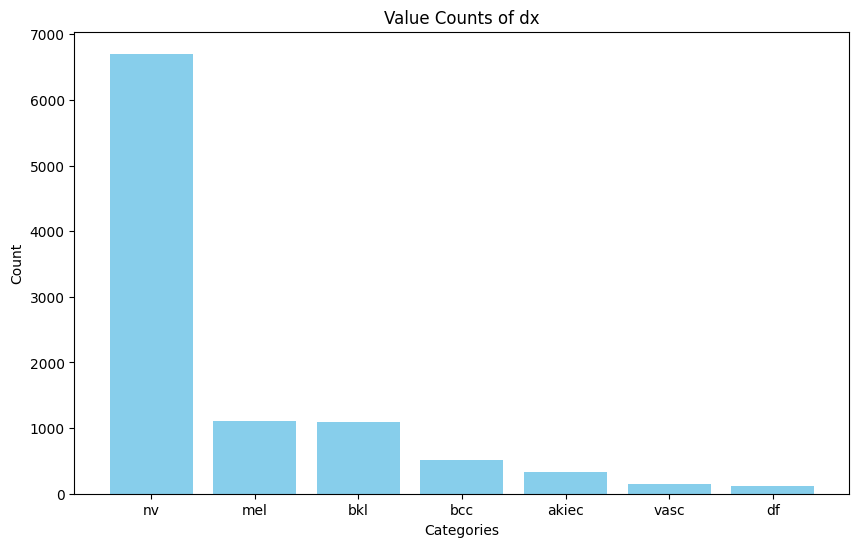

In [ ]:
value_counts = metadata['dx'].value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 6))

# Create the bar plot
plt.bar(value_counts.index, value_counts.values, color='skyblue')

# Add titles and labels
plt.title('Value Counts of dx')
plt.xlabel('Categories')
plt.ylabel('Count')

Malignant:
*  mel (Melanoma)
*  bcc (Basal Cell Carcinoma)

Non-malignant:
* nv (Normal/nevus)
* bkl (Benign keratosis/Basal cell carcinoma)
* akiec (Actinic keratosis)
* vasc (Vascular lesions)
* df (Dermatofibroma)


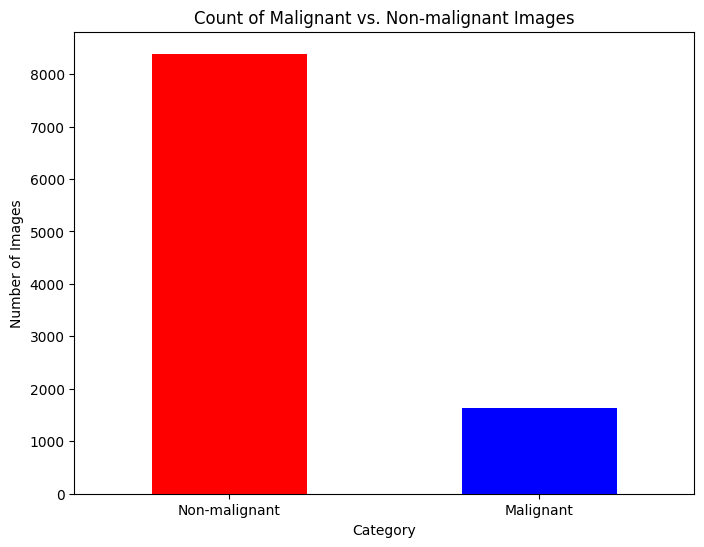

In [5]:
# Define malignant and non-malignant categories
malignant_diagnoses = ['mel', 'bcc']
non_malignant_diagnoses = ['nv', 'bkl', 'akiec', 'vasc', 'df']

# Add a new column to classify diagnoses
metadata['category'] = metadata['dx'].apply(lambda x: 'Malignant' if x in malignant_diagnoses else 'Non-malignant')

# Count the number of images for each category
category_counts = metadata['category'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['red', 'blue'])
plt.title('Count of Malignant vs. Non-malignant Images')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.show()

In [6]:
#creating a column to incle image path
def get_image_path(image_id):
    part_1_path = os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1', f'{image_id}.jpg')
    part_2_path = os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2', f'{image_id}.jpg')

    if os.path.exists(part_1_path):
        return part_1_path
    elif os.path.exists(part_2_path):
        return part_2_path
    else:
        raise FileNotFoundError(f'Image {image_id}.jpg not found in either folder.')

metadata['image_path'] = metadata['image_id'].apply(get_image_path)


In [7]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,category,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Non-malignant,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Non-malignant,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Non-malignant,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Non-malignant,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Non-malignant,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...


In [8]:
metadata.to_csv('updated_dataset_k.csv', index=False)

In [9]:
# df = pd.read_csv('/content/drive/MyDrive/BTP/dataset/updated_dataset.csv')
df = pd.read_csv('/kaggle/working/updated_dataset_k.csv')

In [8]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,category
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Non-malignant
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Non-malignant
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Non-malignant
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Non-malignant
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Non-malignant


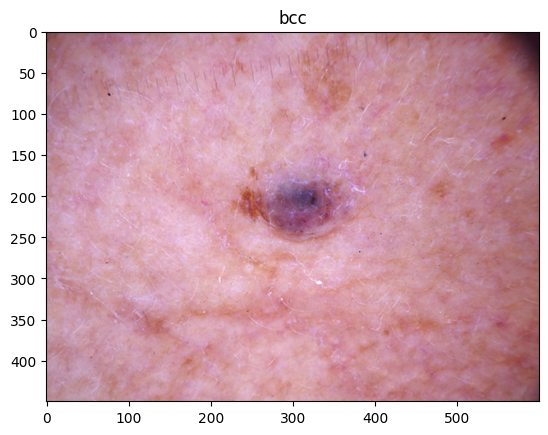

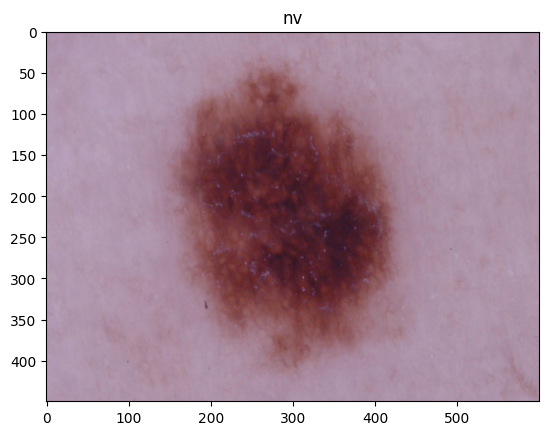

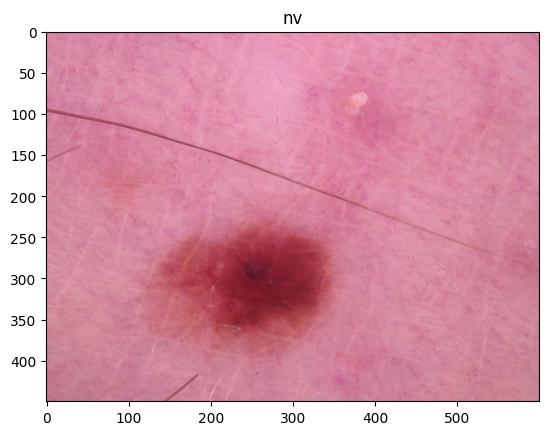

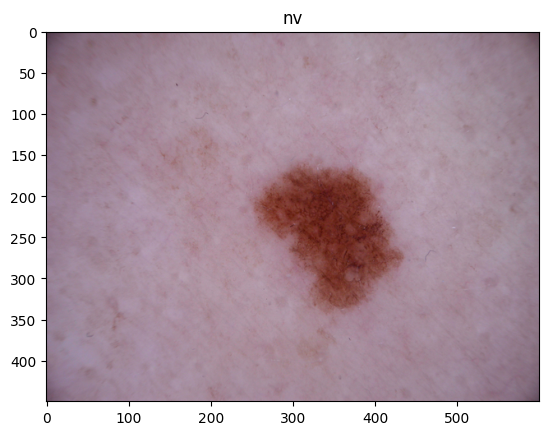

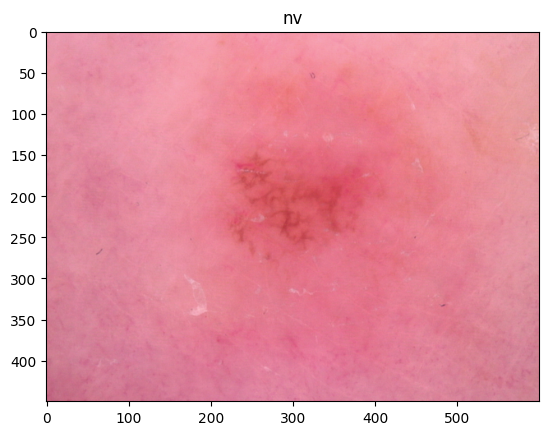

In [ ]:
#Visualising first few images
sample_images = metadata.sample(5)
for _, row in sample_images.iterrows():
    img = Image.open(row['image_path'])
    plt.imshow(img)
    plt.title(row['dx'])
    plt.show()


# Training a base model using Vision Transformer

In [ ]:
#Splitting the dataset into 80:10:10
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'])
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['dx'])


In [30]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [31]:
from torch.utils.data import Dataset, DataLoader

class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Create a mapping from string labels to integers
        self.label_map = {label: idx for idx, label in enumerate(dataframe['dx'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path)

        # Convert label to integer
        label = self.dataframe.iloc[idx]['dx']
        label = self.label_map[label]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [ ]:
train_dataset = SkinCancerDataset(train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = SkinCancerDataset(val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')


In [ ]:
model.classifier = torch.nn.Linear(model.classifier.in_features, 7)

outputs type: <class 'torch.Tensor'>, shape: torch.Size([32, 7])

labels type: <class 'torch.Tensor'>, shape: torch.Size([32])

outputs type: <class 'torch.Tensor'>, shape: torch.Size([32, 7])

labels type: <class 'torch.Tensor'>, shape: torch.Size([32])

outputs type: <class 'torch.Tensor'>, shape: torch.Size([32, 7])

labels type: <class 'torch.Tensor'>, shape: torch.Size([32])

outputs type: <class 'torch.Tensor'>, shape: torch.Size([32, 7])

labels type: <class 'torch.Tensor'>, shape: torch.Size([32])

outputs type: <class 'torch.Tensor'>, shape: torch.Size([32, 7])

labels type: <class 'torch.Tensor'>, shape: torch.Size([32])

outputs type: <class 'torch.Tensor'>, shape: torch.Size([32, 7])

labels type: <class 'torch.Tensor'>, shape: torch.Size([32])

outputs type: <class 'torch.Tensor'>, shape: torch.Size([32, 7])

labels type: <class 'torch.Tensor'>, shape: torch.Size([32])

outputs type: <class 'torch.Tensor'>, shape: torch.Size([32, 7])

labels type: <class 'torch.Tensor'>, s

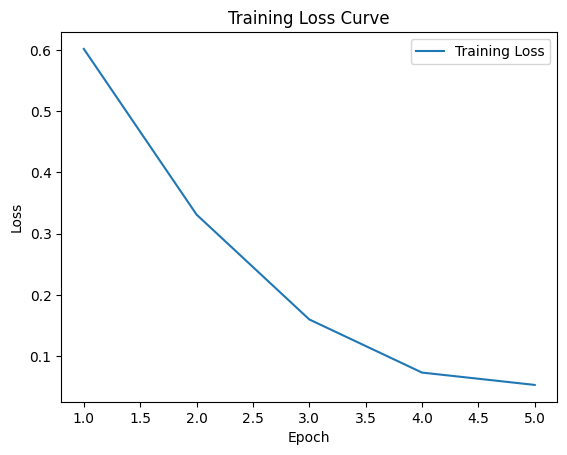

In [ ]:
import torch
import matplotlib.pyplot as plt

# Initialize optimizer, loss function, and number of epochs
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 5

# List to store loss values
loss_values = []

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()  # Set the model to training mode
    for images, labels in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images).logits  # Get logits from the output

        # Check types and shapes
#         print(f"outputs type: {type(outputs)}, shape: {outputs.shape}")
#         print(f"labels type: {type(labels)}, shape: {labels.shape}")

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        epoch_loss += loss.item()  # Accumulate loss

    # Average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Plotting the loss curve
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


Saving the model

In [ ]:
model.eval()

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [40]:
import torch
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=1e-4):

    # Initialize optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    # Lists to store loss values
    train_loss_values = []
    val_loss_values = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Get logits from the output
            
            # Compute loss
            loss = criterion(outputs.logits if isinstance(model, ViTForImageClassification) else outputs, labels)
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters

            epoch_train_loss += loss.item()  # Accumulate loss

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_loss_values.append(avg_train_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')

        # Validation
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                # Compute loss
                loss = criterion(outputs.logits if isinstance(model, ViTForImageClassification) else outputs, labels)
                epoch_val_loss += loss.item()  # Accumulate loss

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_loss_values.append(avg_val_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

    # Plotting the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_loss_values, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_loss_values, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.show()

    return train_loss_values, val_loss_values

# Example usage:
# train_loss_values, val_loss_values = train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=1e-4, device='cuda')


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs.logits if isinstance(model, ViTForImageClassification) else outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Print metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Compute metrics
    report = classification_report(all_labels, all_preds, target_names=train_dataset.label_map.keys())
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)

    return report, conf_matrix


In [41]:
resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 7)
resnet_model = resnet_model.to(device)

Epoch [1/5], Training Loss: 0.6240
Epoch [1/5], Validation Loss: 5.6259
Epoch [2/5], Training Loss: 0.3541
Epoch [2/5], Validation Loss: 6.0953
Epoch [3/5], Training Loss: 0.1942
Epoch [3/5], Validation Loss: 6.6555
Epoch [4/5], Training Loss: 0.1366
Epoch [4/5], Validation Loss: 7.7936
Epoch [5/5], Training Loss: 0.0822
Epoch [5/5], Validation Loss: 9.2085


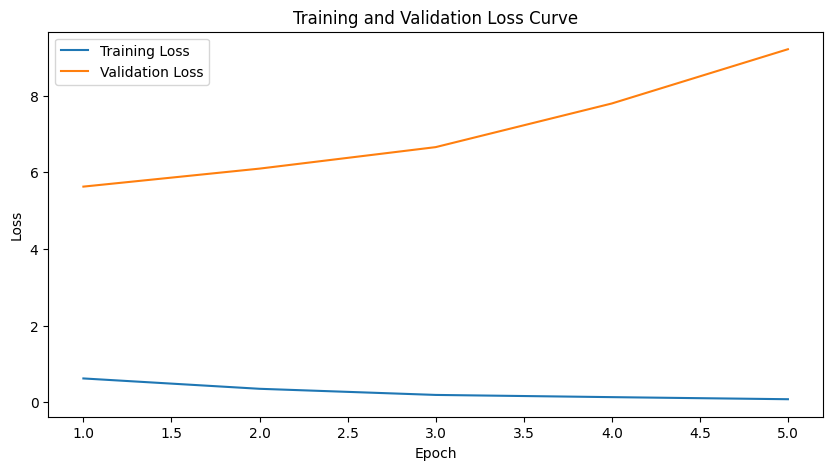

([0.6239848081096709,
  0.3541240508100426,
  0.1942413860256691,
  0.13656996553429807,
  0.08220814196838147],
 [5.6259196400642395,
  6.095294564962387,
  6.6555269211530685,
  7.793634280562401,
  9.208485797047615])

In [42]:
train_model(resnet_model, train_loader,val_loader, num_epochs=5, learning_rate=1e-4)

In [43]:
resnet_model.eval()
torch.save(resnet_model.state_dict(), 'resnet_model.pth')

Testing the model

In [52]:
# Load the test data
test_dataset = SkinCancerDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [48]:
# Evaluate ResNet model
print("Evaluating ResNet model")
evaluate_model(resnet_model, test_loader)

Evaluating ResNet model
Accuracy: 0.0210
Precision: 0.0395
Recall: 0.0210
F1 Score: 0.0222
Classification Report:
               precision    recall  f1-score   support

         bkl       0.10      0.09      0.09       112
          nv       0.00      0.09      0.01        32
         bcc       0.02      0.00      0.00       671
        vasc       0.00      0.00      0.00       110
       akiec       0.07      0.04      0.05        52
         mel       0.00      0.00      0.00        14
          df       1.00      0.45      0.62        11

    accuracy                           0.02      1002
   macro avg       0.17      0.10      0.11      1002
weighted avg       0.04      0.02      0.02      1002

Confusion Matrix:
 [[ 10  37   1   1   3  60   0]
 [  4   3   7   0  18   0   0]
 [  6 652   1   3   1   8   0]
 [ 73  25   2   0   4   6   0]
 [  5   6  39   0   2   0   0]
 [  0   1   0  13   0   0   0]
 [  1   4   0   0   0   1   5]]


('              precision    recall  f1-score   support\n\n         bkl       0.10      0.09      0.09       112\n          nv       0.00      0.09      0.01        32\n         bcc       0.02      0.00      0.00       671\n        vasc       0.00      0.00      0.00       110\n       akiec       0.07      0.04      0.05        52\n         mel       0.00      0.00      0.00        14\n          df       1.00      0.45      0.62        11\n\n    accuracy                           0.02      1002\n   macro avg       0.17      0.10      0.11      1002\nweighted avg       0.04      0.02      0.02      1002\n',
 array([[ 10,  37,   1,   1,   3,  60,   0],
        [  4,   3,   7,   0,  18,   0,   0],
        [  6, 652,   1,   3,   1,   8,   0],
        [ 73,  25,   2,   0,   4,   6,   0],
        [  5,   6,  39,   0,   2,   0,   0],
        [  0,   1,   0,  13,   0,   0,   0],
        [  1,   4,   0,   0,   0,   1,   5]]))

In [49]:
densenet_model = models.densenet121(pretrained=True)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 7)
densenet_model = densenet_model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Training Loss: 0.7108
Epoch [1/5], Validation Loss: 4.5906
Epoch [2/5], Training Loss: 0.3497
Epoch [2/5], Validation Loss: 4.6743
Epoch [3/5], Training Loss: 0.1947
Epoch [3/5], Validation Loss: 5.6949
Epoch [4/5], Training Loss: 0.0997
Epoch [4/5], Validation Loss: 6.8647
Epoch [5/5], Training Loss: 0.0619
Epoch [5/5], Validation Loss: 7.4537


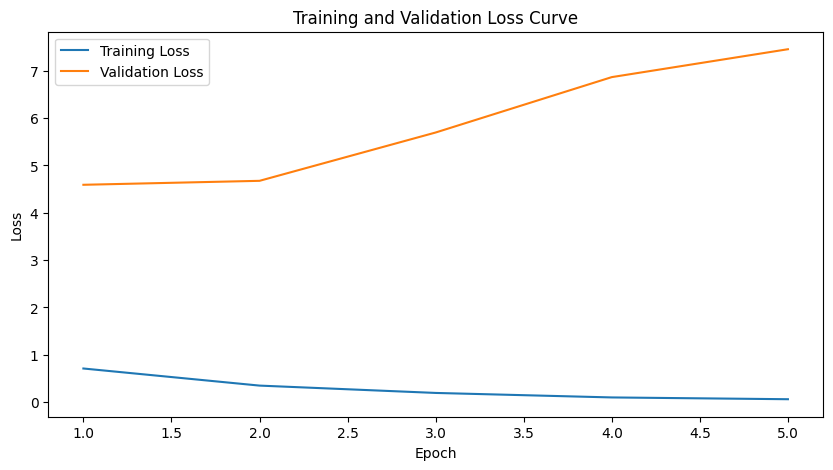

([0.7107750886821177,
  0.34969571010168804,
  0.19465820653089488,
  0.0996517701579102,
  0.061929194330872295],
 [4.590600684285164,
  4.674275875091553,
  5.694857656955719,
  6.864654585719109,
  7.453650489449501])

In [50]:
train_model(densenet_model, train_loader,val_loader, num_epochs=5, learning_rate=1e-4)

In [51]:
densenet_model.eval()
torch.save(densenet_model.state_dict(), 'densenet_model.pth')

In [54]:
# Evaluate DenseNet model
print("Evaluating DenseNet model")
evaluate_model(densenet_model, test_loader)

Evaluating DenseNet model
Accuracy: 0.0170
Precision: 0.0607
Recall: 0.0170
F1 Score: 0.0211
Classification Report:
               precision    recall  f1-score   support

         bkl       0.04      0.04      0.04       112
          nv       0.00      0.03      0.00        32
         bcc       0.06      0.00      0.01       671
        vasc       0.00      0.00      0.00       110
       akiec       0.08      0.06      0.07        52
         mel       0.00      0.00      0.00        14
          df       1.00      0.55      0.71        11

    accuracy                           0.02      1002
   macro avg       0.17      0.10      0.12      1002
weighted avg       0.06      0.02      0.02      1002

Confusion Matrix:
 [[  4  25   1   0   2  80   0]
 [  2   1   1   0  25   3   0]
 [  8 652   3   0   1   7   0]
 [ 80  17   1   0   6   6   0]
 [  3   1  42   0   3   3   0]
 [  0   3   0  11   0   0   0]
 [  1   2   1   0   1   0   6]]


('              precision    recall  f1-score   support\n\n         bkl       0.04      0.04      0.04       112\n          nv       0.00      0.03      0.00        32\n         bcc       0.06      0.00      0.01       671\n        vasc       0.00      0.00      0.00       110\n       akiec       0.08      0.06      0.07        52\n         mel       0.00      0.00      0.00        14\n          df       1.00      0.55      0.71        11\n\n    accuracy                           0.02      1002\n   macro avg       0.17      0.10      0.12      1002\nweighted avg       0.06      0.02      0.02      1002\n',
 array([[  4,  25,   1,   0,   2,  80,   0],
        [  2,   1,   1,   0,  25,   3,   0],
        [  8, 652,   3,   0,   1,   7,   0],
        [ 80,  17,   1,   0,   6,   6,   0],
        [  3,   1,  42,   0,   3,   3,   0],
        [  0,   3,   0,  11,   0,   0,   0],
        [  1,   2,   1,   0,   1,   0,   6]]))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Load the test data
test_dataset = SkinCancerDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Move model to evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
all_labels = []
all_preds = []

# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        # Perform inference
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)

        # Store labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_df['dx'].unique()))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


# Applying Some techniques like Data Augmentation and weighting of classes before training the model

In [ ]:
torch.cuda.empty_cache()

In [9]:
#Splitting the dataset into 80:10:10
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['dx'])
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['dx'])

In [10]:
# Define data augmentation and normalization transforms
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
from torch.utils.data import DataLoader, Dataset

In [12]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(dataframe['dx'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path)
        label = self.dataframe.iloc[idx]['dx']
        label = self.label_map[label]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)


In [13]:
train_dataset = SkinCancerDataset(train_df, transform=transform_aug)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,pin_memory=True)

In [14]:
# Compute and move class weights to the GPU
labels = train_df['dx'].map({label: idx for idx, label in enumerate(train_df['dx'].unique())}).values
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [15]:
# Print class weights with corresponding class labels
for label, weight in zip(np.unique(labels), class_weights):
    print(f"Class: {label}, Weight: {weight.item()}")


Class: 0, Weight: 0.21338020265102386
Class: 1, Weight: 1.2860352993011475
Class: 2, Weight: 1.3021290302276611
Class: 3, Weight: 4.368593215942383
Class: 4, Weight: 2.7848453521728516
Class: 5, Weight: 10.04010009765625
Class: 6, Weight: 12.440994262695312


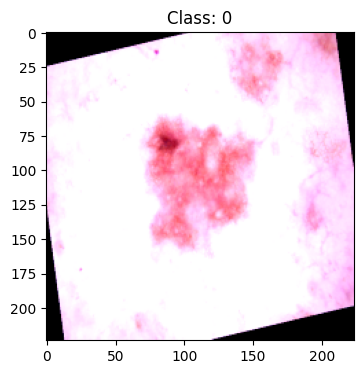

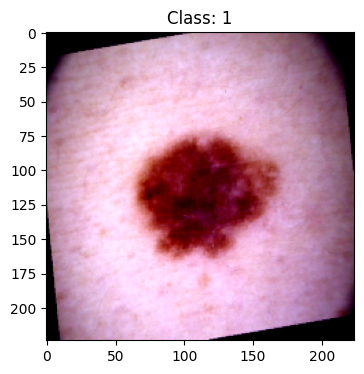

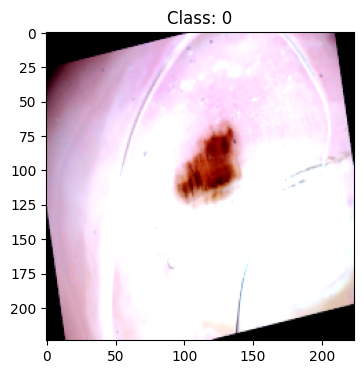

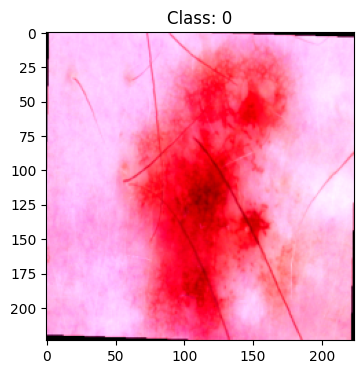

In [16]:
import torchvision

# Get a batch of images from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use next on the iterator

# Function to unnormalize and display images
def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()


for i in range(4):  # Display the first 4 images in the batch
    imshow(images[i], title=f"Class: {labels[i].item()}")


In [ ]:
from transformers import ViTForImageClassification
# Initialize model and move to GPU
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.classifier = torch.nn.Linear(model.classifier.in_features, 7)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 

The secret `HF_TOKEN` does not exist in your Colab secrets.

To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.

You will be able to reuse this secret in all of your notebooks.

Please note that authentication is recommended but still optional to access public models or datasets.

  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [17]:
# Initialize loss function and optimizer
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
loss_values = []


NameError: name 'model' is not defined

In [ ]:
def training(model, num_epochs, criterion, optimizer, train_loader):
  for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')



In [ ]:
def plot_training_loss(num_epochs, loss_values):
  # Plotting the loss curve
  plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss Curve')
  plt.legend()
  plt.show()


In [ ]:
training(model, num_epochs, criterion, optimizer, train_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


Epoch [1/10], Loss: 1.1468

Epoch [2/10], Loss: 0.7107

Epoch [3/10], Loss: 0.6338

Epoch [4/10], Loss: 0.4325

Epoch [5/10], Loss: 0.3609

Epoch [6/10], Loss: 0.2749

Epoch [7/10], Loss: 0.2341

Epoch [8/10], Loss: 0.2094

Epoch [9/10], Loss: 0.2481

Epoch [10/10], Loss: 0.1955


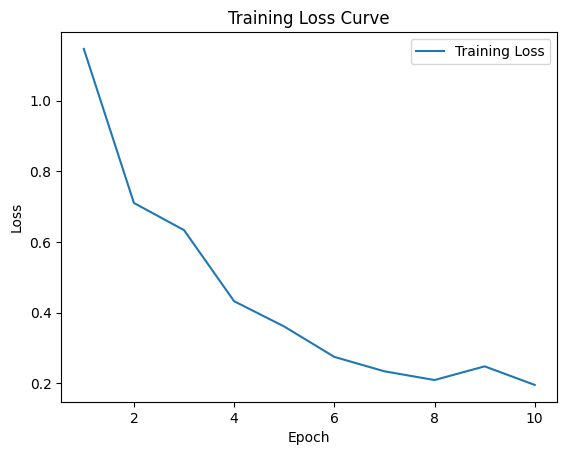

In [ ]:
plot_training_loss(num_epochs, loss_values)

In [ ]:
model.eval()
torch.save(model.state_dict(), 'model_vit_aug.pth')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Load the test data
test_dataset = SkinCancerDataset(test_df, transform=transform_aug)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Move model to evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
all_labels = []
all_preds = []

# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        # Perform inference
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)

        # Store labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_df['dx'].unique()))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Accuracy: 0.0160

Precision: 0.0894

Recall: 0.0160

F1 Score: 0.0251



Classification Report:

              precision    recall  f1-score   support



          nv       0.12      0.02      0.03       671

         bcc       0.01      0.02      0.01        52

       akiec       0.00      0.00      0.00        32

         mel       0.00      0.00      0.00       112

        vasc       0.02      0.07      0.03        14

         bkl       0.11      0.02      0.03       110

          df       0.00      0.00      0.00        11



    accuracy                           0.02      1002

   macro avg       0.04      0.02      0.01      1002

weighted avg       0.09      0.02      0.03      1002





Confusion Matrix:

[[ 12  38 613   1   2   5   0]

 [  0   1   1   3  47   0   0]

 [  3   5   0  22   1   1   0]

 [  6  90  15   0   0   1   0]

 [  0   0   0   0   1   0  13]

 [ 83  11   9   2   3   2   0]

 [  0   0   0   0   1  10   0]]


# Using only data Augmentation and then ensemble model

And early stopping , regularisation , droupouts to prevent overfitting

In [10]:
import torch.nn as nn
from torchvision import models, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor

In [11]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(dataframe['dx'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path)
        label = self.dataframe.iloc[idx]['dx']
        label = self.label_map[label]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [12]:
class CustomSkinCancerDataset(Dataset):
    def __init__(self, dataframe, class_counts, threshold, basic_transform=None, augmentation_transform=None):
        self.dataframe = dataframe
        self.basic_transform = basic_transform
        self.augmentation_transform = augmentation_transform
        self.class_counts = class_counts
        self.threshold = threshold
        self.label_map = {label: idx for idx, label in enumerate(dataframe['dx'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert("RGB")  # Ensure image is in RGB format

        label = self.dataframe.iloc[idx]['dx']
        label = self.label_map[label]

        # Apply augmentation if the class count is below the threshold
        if self.class_counts[label] < self.threshold and self.augmentation_transform:
            image = self.augmentation_transform(image)
        elif self.basic_transform:
            image = self.basic_transform(image)

        return image, torch.tensor(label, dtype=torch.long)



In [13]:
# Define basic transformations for all images
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define additional augmentation transformations
augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),   # Augmentation: Random Horizontal Flip
    transforms.RandomVerticalFlip(),     # Augmentation: Random Vertical Flip
    transforms.RandomRotation(30),       # Augmentation: Random Rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # Augmentation: Random color adjustments
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['dx'])
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['dx'])

In [15]:
# Class counts as provided
class_counts = {
    0: 6705,  # nv
    1: 1113,  # mel
    2: 1099,  # bkl
    3: 514,   # bcc
    4: 327,   # akiec
    5: 142,   # vasc
    6: 115    # df
}

# Define augmentation threshold
largest_class_count = max(class_counts.values())
threshold = 0.2 * largest_class_count  #  20% of the largest class

# Initialize datasets
train_dataset = CustomSkinCancerDataset(
    train_df,
    class_counts,
    threshold,
    basic_transform=basic_transform,
    augmentation_transform=augmentation_transform
)
val_dataset = SkinCancerDataset(val_df, transform=basic_transform)
test_dataset = SkinCancerDataset(test_df, transform=basic_transform)

# Initialize dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [16]:
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
vit_model.classifier = nn.Linear(vit_model.classifier.in_features, 7)
vit_model = vit_model.to(device)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [17]:
resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 7)
resnet_model = resnet_model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s] 


In [18]:
densenet_model = models.densenet121(pretrained=True)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 7)
densenet_model = densenet_model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 148MB/s] 


In [26]:
def train_model(model, train_loader, val_loader, num_epochs=15, patience=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # L2 Regularization
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)
    
    # Early stopping initialization
    best_val_loss = np.inf
    epochs_no_improve = 0

    # Lists to store loss values
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.logits if isinstance(model, ViTForImageClassification) else outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}')

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs.logits if isinstance(model, ViTForImageClassification) else outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss}')

        # Learning rate scheduler
        scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs.')
                break

    # Plotting the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs.logits if isinstance(model, ViTForImageClassification) else outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute metrics
    report = classification_report(all_labels, all_preds, target_names=train_dataset.label_map.keys())
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)

    return report, conf_matrix


In [22]:
import torch.optim as optim 

Epoch 1, Training Loss: 0.22296513186203282
Epoch 1, Validation Loss: 3.042030010904585
Epoch 2, Training Loss: 0.21023410487666302
Epoch 2, Validation Loss: 1.9650975522540866
Epoch 3, Training Loss: 0.19919698804024627
Epoch 3, Validation Loss: 2.768395087075612
Early stopping triggered after 3 epochs.


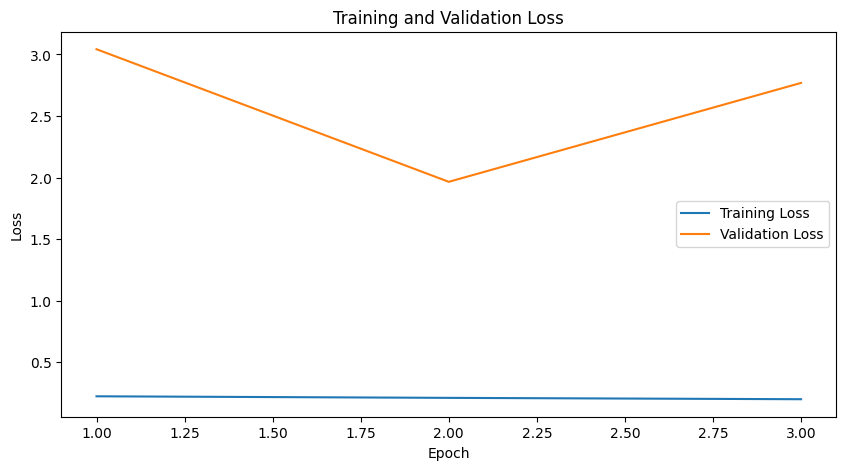

In [27]:
# Train Vision Transformer model
train_model(vit_model, train_loader, val_loader, num_epochs=15)
torch.save(vit_model.state_dict(), 'vit_model_ao.pth')


In [28]:
print("Evaluating Vision Transformer model")
evaluate_model(vit_model, test_loader)

Evaluating Vision Transformer model
Classification Report:
               precision    recall  f1-score   support

          nv       0.11      1.00      0.20       112
         mel       1.00      0.00      0.00       671
         bkl       0.00      0.00      0.00       110
          df       0.00      0.00      0.00        52
         bcc       0.00      0.00      0.00        14
       akiec       0.00      0.00      0.00        32
        vasc       0.00      0.00      0.00        11

    accuracy                           0.11      1002
   macro avg       0.16      0.14      0.03      1002
weighted avg       0.68      0.11      0.02      1002

Confusion Matrix:
 [[112   0   0   0   0   0   0]
 [670   1   0   0   0   0   0]
 [110   0   0   0   0   0   0]
 [ 52   0   0   0   0   0   0]
 [ 10   0   0   0   0   0   4]
 [ 32   0   0   0   0   0   0]
 [ 11   0   0   0   0   0   0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


('              precision    recall  f1-score   support\n\n          nv       0.11      1.00      0.20       112\n         mel       1.00      0.00      0.00       671\n         bkl       0.00      0.00      0.00       110\n          df       0.00      0.00      0.00        52\n         bcc       0.00      0.00      0.00        14\n       akiec       0.00      0.00      0.00        32\n        vasc       0.00      0.00      0.00        11\n\n    accuracy                           0.11      1002\n   macro avg       0.16      0.14      0.03      1002\nweighted avg       0.68      0.11      0.02      1002\n',
 array([[112,   0,   0,   0,   0,   0,   0],
        [670,   1,   0,   0,   0,   0,   0],
        [110,   0,   0,   0,   0,   0,   0],
        [ 52,   0,   0,   0,   0,   0,   0],
        [ 10,   0,   0,   0,   0,   0,   4],
        [ 32,   0,   0,   0,   0,   0,   0],
        [ 11,   0,   0,   0,   0,   0,   0]]))

Epoch 1, Training Loss: 0.44726892996453
Epoch 1, Validation Loss: 2.7252469469630527
Epoch 2, Training Loss: 0.3555570200918439
Epoch 2, Validation Loss: 2.5267562043099177
Epoch 3, Training Loss: 0.31986141860663536
Epoch 3, Validation Loss: 2.495534084145985
Epoch 4, Training Loss: 0.30100960458838893
Epoch 4, Validation Loss: 2.7616243419193087
Epoch 5, Training Loss: 0.2729963811482498
Epoch 5, Validation Loss: 3.0206335116000402


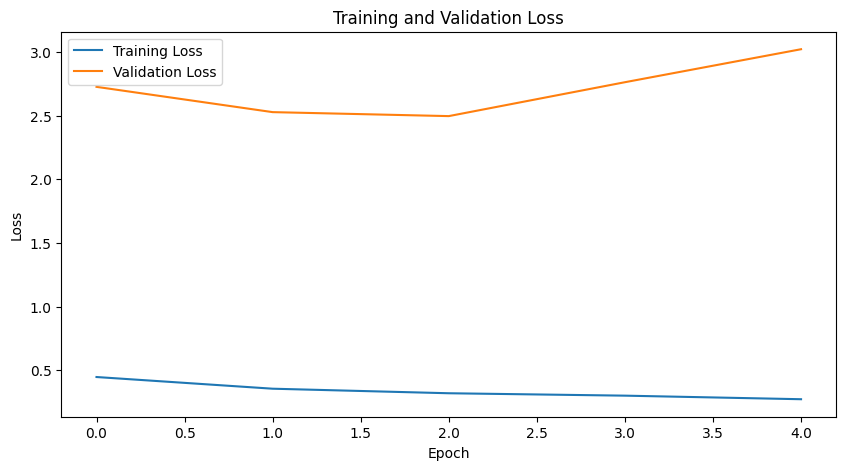

In [19]:
# Train ResNet model
train_model(resnet_model, train_loader, val_loader, num_epochs=15)
torch.save(resnet_model.state_dict(), 'resnet_model_ao.pth')

In [20]:
# Evaluate ResNet model
print("Evaluating ResNet model")
evaluate_model(resnet_model, test_loader)

Evaluating ResNet model
Classification Report:
               precision    recall  f1-score   support

          nv       0.68      1.00      0.81       671
         mel       0.00      0.00      0.00       112
         bkl       0.00      0.00      0.00       110
         bcc       0.00      0.00      0.00        14
          df       0.00      0.00      0.00        32
        vasc       0.00      0.00      0.00        11
       akiec       0.00      0.00      0.00        52

    accuracy                           0.67      1002
   macro avg       0.10      0.14      0.12      1002
weighted avg       0.45      0.67      0.54      1002

Confusion Matrix:
 [[671   0   0   0   0   0   0]
 [107   0   0   0   0   1   4]
 [110   0   0   0   0   0   0]
 [ 10   0   0   0   0   4   0]
 [ 28   0   0   0   0   0   4]
 [ 11   0   0   0   0   0   0]
 [ 52   0   0   0   0   0   0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


('              precision    recall  f1-score   support\n\n          nv       0.68      1.00      0.81       671\n         mel       0.00      0.00      0.00       112\n         bkl       0.00      0.00      0.00       110\n         bcc       0.00      0.00      0.00        14\n          df       0.00      0.00      0.00        32\n        vasc       0.00      0.00      0.00        11\n       akiec       0.00      0.00      0.00        52\n\n    accuracy                           0.67      1002\n   macro avg       0.10      0.14      0.12      1002\nweighted avg       0.45      0.67      0.54      1002\n',
 array([[671,   0,   0,   0,   0,   0,   0],
        [107,   0,   0,   0,   0,   1,   4],
        [110,   0,   0,   0,   0,   0,   0],
        [ 10,   0,   0,   0,   0,   4,   0],
        [ 28,   0,   0,   0,   0,   0,   4],
        [ 11,   0,   0,   0,   0,   0,   0],
        [ 52,   0,   0,   0,   0,   0,   0]]))

Epoch 1, Training Loss: 0.4599334078128942
Epoch 1, Validation Loss: 2.2316862368394457
Epoch 2, Training Loss: 0.3223125203596261
Epoch 2, Validation Loss: 2.3915781610541873
Epoch 3, Training Loss: 0.27934196514789456
Epoch 3, Validation Loss: 2.6170385744836597
Epoch 4, Training Loss: 0.25348033270465875
Epoch 4, Validation Loss: 2.711342960123032
Epoch 5, Training Loss: 0.2393327008750654
Epoch 5, Validation Loss: 2.3489152301871585


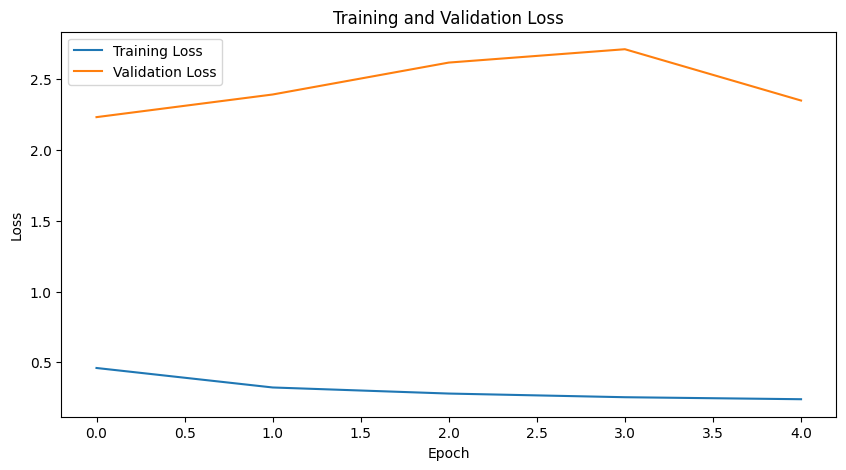

In [21]:
# Train DenseNet model
train_model(densenet_model, train_loader, val_loader, num_epochs=15)
torch.save(densenet_model.state_dict(), 'densenet_model_ao.pth')

In [22]:
# Evaluate ResNet model
print("Evaluating DenseNet model")
evaluate_model(densenet_model, test_loader)

Evaluating DenseNet model
Classification Report:
               precision    recall  f1-score   support

          nv       0.70      1.00      0.82       671
         mel       0.00      0.00      0.00       112
         bkl       0.00      0.00      0.00       110
         bcc       0.00      0.00      0.00        14
          df       0.00      0.00      0.00        32
        vasc       0.00      0.00      0.00        11
       akiec       0.12      0.02      0.03        52

    accuracy                           0.67      1002
   macro avg       0.12      0.15      0.12      1002
weighted avg       0.47      0.67      0.55      1002

Confusion Matrix:
 [[670   0   0   1   0   0   0]
 [112   0   0   0   0   0   0]
 [106   0   0   2   0   0   2]
 [ 14   0   0   0   0   0   0]
 [ 24   0   0   3   0   0   5]
 [  7   0   0   1   3   0   0]
 [ 27   0   0  24   0   0   1]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


('              precision    recall  f1-score   support\n\n          nv       0.70      1.00      0.82       671\n         mel       0.00      0.00      0.00       112\n         bkl       0.00      0.00      0.00       110\n         bcc       0.00      0.00      0.00        14\n          df       0.00      0.00      0.00        32\n        vasc       0.00      0.00      0.00        11\n       akiec       0.12      0.02      0.03        52\n\n    accuracy                           0.67      1002\n   macro avg       0.12      0.15      0.12      1002\nweighted avg       0.47      0.67      0.55      1002\n',
 array([[670,   0,   0,   1,   0,   0,   0],
        [112,   0,   0,   0,   0,   0,   0],
        [106,   0,   0,   2,   0,   0,   2],
        [ 14,   0,   0,   0,   0,   0,   0],
        [ 24,   0,   0,   3,   0,   0,   5],
        [  7,   0,   0,   1,   3,   0,   0],
        [ 27,   0,   0,  24,   0,   0,   1]]))

In [27]:
# Load ViT model
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
vit_model.classifier = nn.Linear(vit_model.classifier.in_features, 7)
vit_model.load_state_dict(torch.load('/kaggle/working/vit_model_a.pth'))
vit_model = vit_model.to(device)

# Load ResNet model
resnet_model = models.resnet50(pretrained=False)  # pretrained=False since you're loading your own weights
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 7)
resnet_model.load_state_dict(torch.load('/kaggle/working/resnet_model_a.pth'))
resnet_model = resnet_model.to(device)

# Load DenseNet model
densenet_model = models.densenet121(pretrained=False)  # pretrained=False since you're loading your own weights
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 7)
densenet_model.load_state_dict(torch.load('/kaggle/working/densenet_model_a.pth'))
densenet_model = densenet_model.to(device)


/tmp/ipykernel_36/4015398200.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load('/kaggle/working/vit_model_a.pth'))
/opt/conda/lib/pyth

In [29]:
def ensemble_predict(models, loader):
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for images, _ in loader:
                images = images.to(device)
                outputs = model(images)
                preds.append(outputs.logits if isinstance(model, ViTForImageClassification) else outputs)
        all_preds.append(torch.cat(preds))

    # Average the predictions
    avg_preds = torch.mean(torch.stack(all_preds), dim=0)
    return torch.argmax(avg_preds, dim=1)

In [31]:
models = [vit_model, resnet_model, densenet_model]
ensemble_predictions = ensemble_predict(models, test_loader)

# # Convert predictions back to labels
# label_map_inv = {v: k for k, v in train_dataset.label_map.items()}
# predicted_labels = [label_map_inv[pred.item()] for pred in ensemble_predictions]

# Evaluate the ensemble predictions
from sklearn.metrics import classification_report, confusion_matrix
true_labels = test_df['dx'].map(train_dataset.label_map).values  # Numeric labels
predicted_labels = ensemble_predictions.cpu().numpy() 

print(classification_report(true_labels, predicted_labels))
print(confusion_matrix(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.67      1.00      0.80       671
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00       110
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00        11
           5       1.00      0.07      0.13        14
           6       1.00      0.03      0.06        32

    accuracy                           0.67      1002
   macro avg       0.38      0.16      0.14      1002
weighted avg       0.50      0.67      0.54      1002

[[671   0   0   0   0   0   0]
 [112   0   0   0   0   0   0]
 [110   0   0   0   0   0   0]
 [ 52   0   0   0   0   0   0]
 [ 11   0   0   0   0   0   0]
 [ 13   0   0   0   0   1   0]
 [ 31   0   0   0   0   0   1]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
